## Project Initialisation

### Import librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
import ast

from transformers import pipeline
from collections import defaultdict
from transformers import pipeline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from statsmodels import tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants 

In [3]:
RAW_DATA_FOLDER_PATH = 'data/raw/'
PROCESSED_DATA_FOLDER_PATH = 'data/processed/'

In [4]:
from src.data.data_transformer_copie import *

In [5]:
movies_complete_df=preprocess_movies_complete(from_files=True)
movies_complete_df

,wikipedia_movie_id,movie_name,movie_release_date,movie_genres,movie_countries,Director,Gender,actor_genders,actor_age,bechdel_rating,revenue,budget,average_rating,num_votes,emotion_scores,dominant_emotion,char_M,char_F,char_tot
0,975900,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",[United States],John Carpenter,M,"[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, nan...",3.0,14010832.0,28000000.0,4.9,58732.0,"{'anger': 0.13912621214985849, 'disgust': 0.19...",fear,11,6,17
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,"[Horror, Biographical and Real-Life Inspired, ...",[United States],NaN,NaN,"[M, F, M, F, M, M, M, F, F, M, M, M, M, M, M]","[nan, 43.0, nan, nan, 50.0, 55.0, 40.0, 35.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,4,15
2,28463795,Brun bitter,1988,"[Crime and Mystery, Drama]",[Norway],NaN,NaN,"[M, F, M, F]","[33.0, 28.0, 40.0, 30.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,4
3,9363483,White Of The Eye,1987,[Thriller],[United Kingdom],Donald Cammell,M,"[M, F]","[32.0, 26.0]",NaN,NaN,NaN,NaN,NaN,"{'anger': 0.33140772208571434, 'disgust': 0.20...",anger,1,1,2
4,261236,A Woman in Flames,1983,[Drama],[Germany],Robert van Ackeren,M,"[F, M, M]","[32.0, 32.0, 35.0]",NaN,NaN,NaN,5.9,648.0,"{'anger': 0.2845786526799202, 'disgust': 0.379...",disgust,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60342,23851782,The Ghost Train,1941,"[Crime and Mystery, Thriller, Comedy, Horror]",[United Kingdom],Walter Forde,M,"[F, M, F, M, M, M, F, M, M, F, M, M, M]","[nan, 37.0, 27.0, 34.0, 40.0, nan, 22.0, nan, ...",NaN,NaN,NaN,6.1,1711.0,"{'anger': 0.2017415647378898, 'disgust': 0.071...",fear,9,4,13
60343,32468537,Shadow Boxing 2,2007,"[Biographical and Real-Life Inspired, Crime an...",[Russia],NaN,NaN,"[M, F, M, M, M, M, M, M, M, M]","[45.0, nan, nan, 49.0, nan, nan, nan, nan, nan...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,10
60344,9971909,Another Nice Mess,1972,[Comedy],[United States],Bob Einstein,M,"[M, M]","[33.0, 53.0]",NaN,NaN,NaN,5.9,117.0,NaN,NaN,2,0,2
60345,913762,The Super Dimension Fortress Macross II: Lover...,1992,"[Science Fiction, World Cinema, Adventure, Ani...",[Japan],NaN,NaN,"[M, M, F, F, M, M, M, M, F, M, M, F, M, F, M]","[23.0, 22.0, 22.0, 25.0, 52.0, nan, 32.0, 32.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,5,15


### Preprocessing of the plot summaries dataset

In [6]:
def preprocessing_plot_summaries(movies_complete_df):
    # Load the plot summaries
    column_names = ["wikipedia_movie_id", "plot"]
    df_plot_summaries = pd.read_csv(RAW_DATA_FOLDER_PATH + 'plot_summaries.txt', sep="\t", names=column_names)

    # Filtering of the movies which are not in our other complete dataset
    df_plot_summaries_filtered = df_plot_summaries[df_plot_summaries['wikipedia_movie_id'].isin(movies_complete_df['wikipedia_movie_id'])]
    df_plot_summaries_filtered.reset_index(drop=True, inplace=True)

    # For more readibility
    df_plot_summaries = df_plot_summaries_filtered.copy()

    # Add the movie title to the plot summaries
    df_plot_summaries_filtered['movie_title'] = df_plot_summaries['wikipedia_movie_id'].map(movies_complete_df.set_index('wikipedia_movie_id')['movie_name'].to_dict())

    # Add the director and their gender for each plot summary
    df_plot_summaries['director'] = df_plot_summaries['wikipedia_movie_id'].map(movies_complete_df.set_index('wikipedia_movie_id')['Director'].to_dict())
    df_plot_summaries['director_gender'] = df_plot_summaries['wikipedia_movie_id'].map(movies_complete_df.set_index('wikipedia_movie_id')['Gender'].to_dict())

    # Drop the rows where the director is NaN or the director_gender is NaN
    df_plot_summaries = df_plot_summaries.dropna(subset=['director'])
    df_plot_summaries = df_plot_summaries.dropna(subset=['director_gender'])

    return df_plot_summaries

In [7]:
df_plot_summaries = preprocessing_plot_summaries(movies_complete_df)
df_plot_summaries

,wikipedia_movie_id,plot,director,director_gender
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Pavel Lungin,M
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Shaji Kailas,M
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",Sidney Lanfield Frank Tashlin (uncredited),M
4,595909,Seventh-day Adventist Church pastor Michael Ch...,Fred Schepisi,M
5,5272176,The president is on his way to give a speech. ...,Andy Cheng,M
...,...,...,...,...
35805,30352708,Twenty-something Eun-mo listens to a taxi driv...,Park Chan-ok,M
35806,2867597,"An attempt to bring the famed ""Mr. Bill"" clay ...",Jim Drake,M
35808,1096473,"In 1928 Hollywood, director Leo Andreyev look...",Josef von Sternberg,M
35809,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Hemen Gupta,F


## Sentiment analysis on the plot summaries

### Obtaining emotions for all plot summeries  

In [9]:
# Load the pipeline with a specific emotion model
emotion_pipeline = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

# Function for analyzing the emotion of a text
def emotion_analysis(text):
    chunks = [text[i:i+512] for i in range(0, len(text), 512)]
    results = [emotion_pipeline(chunk) for chunk in chunks]

    # Initialize a dictionary to accumulate scores for each emotion
    emotion_scores = defaultdict(list)

    #Process each chunk and accumulate scores
    for chunk_result in results:
        for emotion in chunk_result:
            for i in range(len(emotion)):
                emotion_scores[emotion[i]['label']].append(emotion[i]['score'])
            #print(emotion_scores[emotion['label']])
            #emotion_scores[emotion['label']].append(emotion['score'])

    # Calculate the average score for each emotion
    average_scores = {emotion: sum(scores) / len(scores) for emotion, scores in emotion_scores.items()}

    return average_scores


# Function for processing all film summaries 
def emotion_score_big_dataset_csv(df, output_file, from_index, to_index, batch_size):
    for i in range(from_index, to_index, batch_size):
        batch = df.iloc[i:i + batch_size]

        batch['emotion_scores'] = batch['plot'].apply(emotion_analysis)
        batch['dominant_emotion'] = batch['emotion_scores'].apply(lambda x: max(x, key=x.get))

        batch.to_csv(output_file, mode='a', index=False, header=not os.path.exists(output_file))


In [ ]:
# Creation of the csv with all the emotions scores
output_file = PROCESSED_DATA_FOLDER_PATH + 'plot_emotions.csv'
emotion_score_big_dataset_csv(df_plot_summaries, output_file, 0, df_plot_summaries.shape[0], batch_size=100)

In [60]:
# Dataframe with the emotions scores
df_plot_emotions = pd.read_csv(PROCESSED_DATA_FOLDER_PATH + 'plot_emotions.csv')

In [8]:
movies_complete_df

,wikipedia_movie_id,movie_name,movie_release_date,movie_genres,movie_countries,Director,Gender,actor_genders,actor_age,bechdel_rating,revenue,budget,average_rating,num_votes,emotion_scores,dominant_emotion,char_M,char_F,char_tot
0,975900,Ghosts of Mars,2001,"[Thriller, Science Fiction, Horror, Adventure,...",[United States],John Carpenter,M,"[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, nan...",3.0,14010832.0,28000000.0,4.9,58732.0,"{'anger': 0.13912621214985849, 'disgust': 0.19...",fear,11,6,17
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,"[Horror, Biographical and Real-Life Inspired, ...",[United States],NaN,NaN,"[M, F, M, F, M, M, M, F, F, M, M, M, M, M, M]","[nan, 43.0, nan, nan, 50.0, 55.0, 40.0, 35.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,4,15
2,28463795,Brun bitter,1988,"[Crime and Mystery, Drama]",[Norway],NaN,NaN,"[M, F, M, F]","[33.0, 28.0, 40.0, 30.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,4
3,9363483,White Of The Eye,1987,[Thriller],[United Kingdom],Donald Cammell,M,"[M, F]","[32.0, 26.0]",NaN,NaN,NaN,NaN,NaN,"{'anger': 0.33140772208571434, 'disgust': 0.20...",anger,1,1,2
4,261236,A Woman in Flames,1983,[Drama],[Germany],Robert van Ackeren,M,"[F, M, M]","[32.0, 32.0, 35.0]",NaN,NaN,NaN,5.9,648.0,"{'anger': 0.2845786526799202, 'disgust': 0.379...",disgust,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60342,23851782,The Ghost Train,1941,"[Crime and Mystery, Thriller, Comedy, Horror]",[United Kingdom],Walter Forde,M,"[F, M, F, M, M, M, F, M, M, F, M, M, M]","[nan, 37.0, 27.0, 34.0, 40.0, nan, 22.0, nan, ...",NaN,NaN,NaN,6.1,1711.0,"{'anger': 0.2017415647378898, 'disgust': 0.071...",fear,9,4,13
60343,32468537,Shadow Boxing 2,2007,"[Biographical and Real-Life Inspired, Crime an...",[Russia],NaN,NaN,"[M, F, M, M, M, M, M, M, M, M]","[45.0, nan, nan, 49.0, nan, nan, nan, nan, nan...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,10
60344,9971909,Another Nice Mess,1972,[Comedy],[United States],Bob Einstein,M,"[M, M]","[33.0, 53.0]",NaN,NaN,NaN,5.9,117.0,NaN,NaN,2,0,2
60345,913762,The Super Dimension Fortress Macross II: Lover...,1992,"[Science Fiction, World Cinema, Adventure, Ani...",[Japan],NaN,NaN,"[M, M, F, F, M, M, M, M, F, M, M, F, M, F, M]","[23.0, 22.0, 22.0, 25.0, 52.0, nan, 32.0, 32.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,5,15


### Preprocessing plot_summaries

In [6]:
def preprocessing_plot_summaries(movies_complete_df):
    #df_plot_emotions = movies_complete_df.copy(deep = True)
    df_plot_emotions = movies_complete_df[['wikipedia_movie_id', 'Director', 'Gender', 'emotion_scores', 'dominant_emotion']]
    df_plot_emotions['emotion_scores'] = df_plot_emotions.dropna(subset=['emotion_scores'])
    return df_plot_emotions

    

In [7]:
df_plot_emotions_test = preprocessing_plot_summaries(movies_complete_df)
df_plot_emotions_test

ValueError: Columns must be same length as key

### Graphs

#### Distribution of emotions in plot summaries

In [6]:
# Funtion to plot the distribution of emotions, in proportion to the scores obtained in the plot summaries
def graph_emotions(df):
    emotion_totals = {
    'anger': 0,
    'disgust': 0,
    'fear': 0,
    'joy': 0,
    'neutral': 0,
    'sadness': 0,
    'surprise': 0
    }
    for emotion_score in df['emotion_scores']:
        scores = ast.literal_eval(emotion_score)
        for emotion, score in scores.items():
            emotion_totals[emotion] += score

    fig = px.pie(
        values=list(emotion_totals.values()),
        names=list(emotion_totals.keys()),
        title='Emotions in Plot Summaries',
        color_discrete_sequence=px.colors.qualitative.Set2
    )
    fig.show()



In [7]:
graph_emotions(df_plot_emotions)

#### Ratio emotion by director gender

In [8]:
def ratio_emotion_by_director_gender(df_plot_emotions):
    df_plot_emotions_women = df_plot_emotions[df_plot_emotions['director_gender'] == 'F']
    df_plot_emotions_men = df_plot_emotions[df_plot_emotions['director_gender'] == 'M']

    emotion_totals_women = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'neutral': 0,
        'sadness': 0,
        'surprise': 0
    }
    emotion_totals_men = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'neutral': 0,
        'sadness': 0,
        'surprise': 0
    }

    for emotion_score in df_plot_emotions_women['emotion_scores']:
        scores = ast.literal_eval(emotion_score)
        for emotion, score in scores.items():
            emotion_totals_women[emotion] += score

    for emotion_score in df_plot_emotions_men['emotion_scores']:
        scores = ast.literal_eval(emotion_score)
        for emotion, score in scores.items():
            emotion_totals_men[emotion] += score


    # Calculating ratios
    total_women = sum(emotion_totals_women.values())
    total_men = sum(emotion_totals_men.values())

    ratios_women = {emotion: value / total_women * 100 for emotion, value in emotion_totals_women.items()}
    ratios_men = {emotion: value / total_men * 100 for emotion, value in emotion_totals_men.items()}

    return ratios_women, ratios_men

def graph_ratio_emotion_by_director_gender(ratios_women, ratios_men):
    # Transformation into a DataFrame for Plotly
    df = pd.DataFrame({
        'Emotion': list(ratios_women.keys()),
        'Women': list(ratios_women.values()),
        'Men': list(ratios_men.values())
    })

    fig = px.bar(
        df,
        x='Emotion',
        y=['Women', 'Men'],
        title='Ratio of Emotions by Gender',
        labels={'value': 'Ratio (%)', 'Emotion': 'Emotion'},
        barmode='group',
        color_discrete_map={
            "Women": "royalblue",
            "Men": "gold"
        }
    )

    # 
    fig.update_traces(marker=dict(opacity=0.8))
    fig.update_layout(
        xaxis_title="Emotion",
        yaxis_title="Ratio (%)",
        legend_title="Director Gender",
        template="plotly_white"
    )

    fig.show()

In [9]:
# Graph of the ratio of emotions by director gender
ratios_women, ratios_men = ratio_emotion_by_director_gender(df_plot_emotions)
graph_ratio_emotion_by_director_gender(ratios_women, ratios_men)

#### Radar Ratio emotion by director gender

In [10]:
def graph_ratio_emotion_radar_by_director_gender(ratios_women, ratios_men):
    emotions = list(ratios_women.keys())
    values_women = list(ratios_women.values())
    values_men = list(ratios_men.values())
    
    # To close the radar, add the first dot at the end
    emotions += [emotions[0]]
    values_women += [values_women[0]]
    values_men += [values_men[0]]
    

    fig = go.Figure()
    # Female directors
    fig.add_trace(go.Scatterpolar(
        r=values_women,
        theta=emotions,
        fill='toself',
        name='Female Directors',
        line=dict(color='royalblue'),
        marker=dict(size=6)
    ))
    # Male directors
    fig.add_trace(go.Scatterpolar(
        r=values_men,
        theta=emotions,
        fill='toself',
        name='Male Directors',
        line=dict(color='gold'),
        marker=dict(size=6)
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(visible=True),
        ),
        title='Ratio of Emotion in Plot Summaries by Director Gender',
        legend_title="Director Gender",
        template="plotly_white"
    )

    fig.show()


In [11]:
# radar graph of the ratio of emotions by director
ratios_women, ratios_men = ratio_emotion_by_director_gender(df_plot_emotions)
graph_ratio_emotion_radar_by_director_gender(ratios_women, ratios_men)

## Combining plot summaries analysis with bechdel test

### Data preprocessing for logistic regression model

In [53]:
def logistic_regression_for_bechdel(movies_complete_df):
    df_bechdel = movies_complete_df.copy(deep = True)

    df_bechdel = df_bechdel.dropna(subset=['bechdel_rating', 'emotion_scores'])
    df_bechdel["emotion_scores"] = df_bechdel["emotion_scores"].str.replace("'", '"')
    # Parse the corrected strings into dictionaries
    df_bechdel["emotion_scores"] = df_bechdel["emotion_scores"].apply(json.loads)

    genres_list = df_bechdel.explode('movie_genres')['movie_genres'].unique().tolist()
    countries_list = df_bechdel.explode("movie_countries")["movie_countries"].unique().tolist()
    emotion_list = df_bechdel["dominant_emotion"].unique().tolist()
    # add genre and countries columns
    cols_df = pd.DataFrame(columns= genres_list + countries_list + emotion_list)
    df_bechdel = pd.concat([df_bechdel, cols_df], axis=1).fillna(0).reset_index(drop=True)


    for index, row in df_bechdel.iterrows():
        genres = row["movie_genres"]
        countries = row["movie_countries"]
        emotions_dict = row["emotion_scores"]
        for genre in genres:
            df_bechdel.at[index, genre] = 1
        for country in countries:
            df_bechdel.at[index, country] = 1
        for emotion in emotion_list:
            df_bechdel.at[index, emotion] = emotions_dict[emotion]


    # dropping old unformatted columns
    df_bechdel = df_bechdel.drop(columns=["actor_genders", "movie_genres", "movie_countries", "actor_genders", "emotion_scores", "dominant_emotion", "wikipedia_movie_id", "movie_name", "Director", "actor_age"])
    df_bechdel.columns = df_bechdel.columns.astype(str)

    # simplifying the bechdel_rating column into 0 (fails test) and 1(passes test)
    df_bechdel["bechdel_rating"] = df_bechdel["bechdel_rating"].apply(lambda x: int(0) if (x==0 or x==1 or x==2) else int(1))

    # simplifying the bechdel_rating column into 0 (M) and 1(F)
    df_bechdel["Gender"] = df_bechdel["Gender"].apply(lambda x: int(0) if (x=='M') else int(1))
    

    # preparing data for model
    target_cols = ["bechdel_rating"]
    features_cols = df_bechdel.keys().tolist()
    features_cols.remove(target_cols[0])
    X = df_bechdel[features_cols]
    y = df_bechdel[target_cols]

    # we split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # we squeeze to match the dimensions
    y_test = y_test.squeeze()
    y_train = y_train.squeeze()

    # Load the module
    scaler = StandardScaler()

    # Standardize X train
    scaler.fit(X_train) # used both for X_train and X_test
    X_train_standardized = scaler.transform(X_train)
    X_test_standardized = scaler.transform(X_test)

    # we create the model
    log_reg_model = LogisticRegression(random_state=42, max_iter=500)

    # Fit the model
    log_reg_model.fit(X_train_standardized, y_train)

    y_pred_test = log_reg_model.predict(X_test_standardized)
    y_pred_train = log_reg_model.predict(X_train_standardized)

    print(f'The accuracy score for test set is: {accuracy_score(y_test, y_pred_test)}')
    print(f'The accuracy score for train set is: {accuracy_score(y_train, y_pred_train)}')

    return y_test, y_pred_test, log_reg_model, X_train
        

In [54]:
y_test, y_pred_test, log_reg_model, X_train = logistic_regression_for_bechdel(movies_complete_df)


The accuracy score for test set is: 0.6614950634696756
The accuracy score for train set is: 0.7208892025405786


In [49]:
def plot_confusion_matrix(y_test, y_pred_test):
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)

    # Normalize the confusion matrix to get proportions
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plotting the normalized confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Normalized Random Forest Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

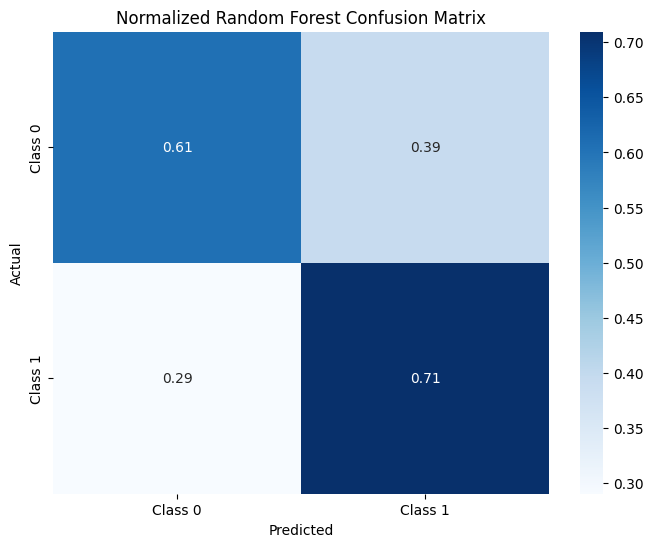

In [50]:
plot_confusion_matrix(y_test, y_pred_test)

In [55]:
def feature_importance(log_reg_model, X_train):
    # Get the feature importance
    selected_features = X_train.columns

    # Get the coefficients from the logistic regression model
    coefficients = log_reg_model.coef_[0]  # For binary classification

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefficients,
        'Importance': abs(coefficients)
    }).sort_values(by='Importance', ascending=False)

    # Display the top 20 features
    return feature_importance_df

In [56]:
feature_importance_df = feature_importance(log_reg_model, X_train)

### Correlation between features --> Faire def plot_correlation

In [ ]:
def preprocessing_bechdel_for_correlation(movies_complete_df):
    df_bechdel = movies_complete_df.copy(deep = True)

    df_bechdel = df_bechdel.dropna(subset=['bechdel_rating', 'emotion_scores'])
    df_bechdel["emotion_scores"] = df_bechdel["emotion_scores"].str.replace("'", '"')
    # Parse the corrected strings into dictionaries
    df_bechdel["emotion_scores"] = df_bechdel["emotion_scores"].apply(json.loads)

    genres_list = df_bechdel.explode('movie_genres')['movie_genres'].unique().tolist()
    countries_list = df_bechdel.explode("movie_countries")["movie_countries"].unique().tolist()
    emotion_list = df_bechdel["dominant_emotion"].unique().tolist()
    # add genre and countries columns
    cols_df = pd.DataFrame(columns= genres_list + countries_list + emotion_list)
    df_bechdel = pd.concat([df_bechdel, cols_df], axis=1).fillna(0).reset_index(drop=True)


    for index, row in df_bechdel.iterrows():
        genres = row["movie_genres"]
        countries = row["movie_countries"]
        emotions_dict = row["emotion_scores"]
        for genre in genres:
            df_bechdel.at[index, genre] = 1
        for country in countries:
            df_bechdel.at[index, country] = 1
        for emotion in emotion_list:
            df_bechdel.at[index, emotion] = emotions_dict[emotion]


    # dropping old unformatted columns
    df_bechdel = df_bechdel.drop(columns=["actor_genders", "movie_genres", "movie_countries", "actor_genders", "emotion_scores", "dominant_emotion", "wikipedia_movie_id", "movie_name", "Director", "actor_age"])
    df_bechdel.columns = df_bechdel.columns.astype(str)

    # simplifying the bechdel_rating column into 0 (fails test) and 1(passes test)
    df_bechdel["bechdel_rating"] = df_bechdel["bechdel_rating"].apply(lambda x: int(0) if (x==0 or x==1 or x==2) else int(1))

    # simplifying the bechdel_rating column into 0 (M) and 1(F)
    df_bechdel["Gender"] = df_bechdel["Gender"].apply(lambda x: int(0) if (x=='M') else int(1))

    return df_bechdel

In [41]:
def plot_correlation(df_bechdel):
    correlations = df_bechdel[['bechdel_rating', 'char_F', 'char_M', "Gender"]].corr()
    # Correlation matrix
    # Correlation values
    bechdel_corr = correlations['bechdel_rating'].drop('bechdel_rating')

    # Plotting
    plt.figure(figsize=(8, 5))
    bechdel_corr.sort_values(ascending=True).plot(kind='barh', color='skyblue')
    plt.title('Correlation with Bechdel Rating')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Variables')
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)  # Mark zero correlation
    plt.tight_layout()
    plt.show()

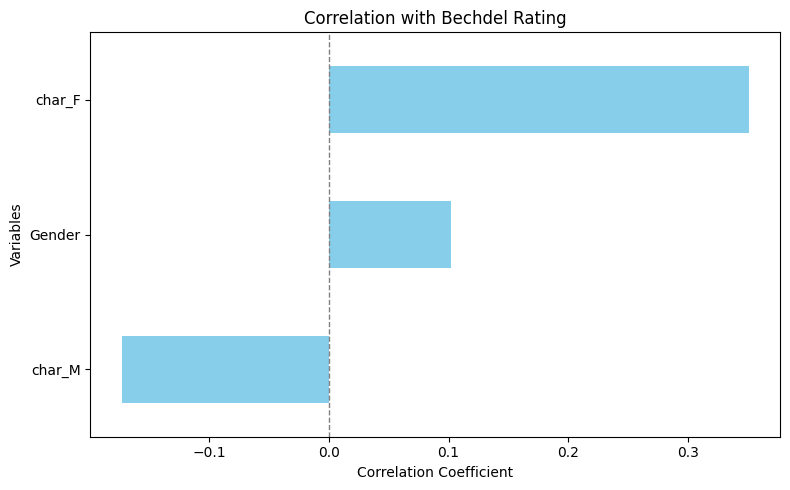

In [ ]:
df_bechdel = preprocessing_bechdel_for_correlation(movies_complete_df)
plot_correlation(df_bechdel)

### Graphs 

In [43]:
def preprocessing_bechdel_for_radar_graph(movies_complete_df):
    df_bechdel = movies_complete_df.copy(deep = True)

    df_bechdel = df_bechdel.dropna(subset=['bechdel_rating', 'emotion_scores'])
    df_bechdel["emotion_scores"] = df_bechdel["emotion_scores"].str.replace("'", '"')
    # Parse the corrected strings into dictionaries
    df_bechdel["emotion_scores"] = df_bechdel["emotion_scores"].apply(json.loads)

    emotion_list = df_bechdel["dominant_emotion"].unique().tolist()
    # add genre and countries columns
    cols_df = pd.DataFrame(columns= emotion_list)
    df_bechdel = pd.concat([df_bechdel, cols_df], axis=1).fillna(0).reset_index(drop=True)


    for index, row in df_bechdel.iterrows():
        emotions_dict = row["emotion_scores"]
        for emotion in emotion_list:
            df_bechdel.at[index, emotion] = emotions_dict[emotion]


    # dropping old unformatted columns
    df_bechdel = df_bechdel.drop(columns=["actor_genders", "movie_genres", "movie_countries", "actor_genders", "emotion_scores", "dominant_emotion", "wikipedia_movie_id", "movie_name", "Director", "actor_age"])
    df_bechdel.columns = df_bechdel.columns.astype(str)

    # simplifying the bechdel_rating column into 0 (fails test) and 1(passes test)
    df_bechdel["bechdel_rating"] = df_bechdel["bechdel_rating"].apply(lambda x: int(0) if (x==0 or x==1 or x==2) else int(1))

    # simplifying the bechdel_rating column into 0 (M) and 1(F)
    df_bechdel["Gender"] = df_bechdel["Gender"].apply(lambda x: int(0) if (x=='M') else int(1))
        
    return df_bechdel

#### Radar Graph for different emotions by bechdel test passed or fail

In [44]:
def graph_emotions_bechdel_combined(df_bechdel):
    # Calculation of the average emotions for each DataFrame
    def compute_mean_emotions(df):
        emotions = ["neutral", "sadness", "anger", "fear", "disgust", "surprise", "joy"]
        return df[emotions].mean()

    # creation of datasets that pass or fail the bechdel test
    bechdel_grade3 = df_bechdel[df_bechdel["bechdel_rating"]==1]
    bechdel_grade012 = df_bechdel[df_bechdel["bechdel_rating"]!=1]

    # Creation of datasets by director gender
    bechdel_grade3_men = bechdel_grade3[bechdel_grade3["Gender"]==0]
    bechdel_grade3_women = bechdel_grade3[bechdel_grade3["Gender"]==1]
    bechdel_grade012_men = bechdel_grade012[bechdel_grade012["Gender"]==0]
    bechdel_grade012_women = bechdel_grade012[bechdel_grade012["Gender"]==1]

    # Data for the graph
    data_women_grade3 = compute_mean_emotions(bechdel_grade3_women)
    data_men_grade3 = compute_mean_emotions(bechdel_grade3_men)

    data_women_grade012 = compute_mean_emotions(bechdel_grade012_women)
    data_men_grade012 = compute_mean_emotions(bechdel_grade012_men)

    # Creation of a graph with two subplots side by side
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'polar'}, {'type': 'polar'}]],      
    )

    # First graph: For films that pass the Bechdel test (Grade 3)
    fig.add_trace(go.Scatterpolar(
        r=data_men_grade3,
        theta=data_men_grade3.index,
        fill='toself',
        name='Men - Bechdel passed',
        marker_color='gold'
    ), row=1, col=1)

    fig.add_trace(go.Scatterpolar(
        r=data_women_grade3,
        theta=data_women_grade3.index,
        fill='toself',
        name='Women - Bechdel passed',
        marker_color='royalblue'
    ), row=1, col=1)

    # Second graph: For films that do not pass the Bechdel test (Grades 0, 1, 2)
    fig.add_trace(go.Scatterpolar(
        r=data_men_grade012,
        theta=data_men_grade012.index,
        fill='toself',
        name='Men - Bechdel failed',
        marker_color='orange'
    ), row=1, col=2)

    fig.add_trace(go.Scatterpolar(
        r=data_women_grade012,
        theta=data_women_grade012.index,
        fill='toself',
        name='Women - Bechdel failed',
        marker_color='blue'
    ), row=1, col=2)

    fig.update_layout(
        title_text="Emotion Distribution by Gender for Bechdel Test Results",
        showlegend=True,
        polar=dict(
            radialaxis=dict(visible=True, range=[0, 0.25])
        ),
        template="plotly_white"
    )

    fig.show()

In [45]:
df_bechdel_graph = preprocessing_bechdel_for_radar_graph(movies_complete_df)
graph_emotions_bechdel_combined(df_bechdel_graph)
